## Read a PLTGEN File, Do Something in Python, then Run R
+ First you need to install RPY2 (use pip install rpy2 or conda install -c r rpy2).
+ See https://rpy2.readthedocs.io/en/version_2.8.x/
+ had to install tzlocal conda install -c conda-forge tzlocal



In [1]:
from readPLTGEN import readPLTGEN

from versioninfo import versions
versions(['numba', 'numpy', 'pandas', 'tables'])

import matplotlib.pyplot as m_plt

In [2]:
import pandas as pd
import numpy as np
import datetime

def readPLTGEN(filename):
    ''' Reads HSPF PLTGEN files and creates a DataFrame that can be plotted like HSP2'''

    foundcols = False
    cols = []
    lst = []
    with open(filename) as f:
        for i, line in enumerate(f):
            if i < 25 and 'LINTYP' in line:
                foundcols = True
            elif i < 25 and line[5:].startswith('Time series'):
                foundcols = False
            elif i < 25 and foundcols:
                header =  line[4:30].strip()
                if not header:
                    foundcols = False
                else:
                    cols.append(header)

            if i > 25:
                y, mm, d, h, m = line[4:22].split()
                if int(h) == 24:
                    d = [datetime.datetime(int(y), int(mm), int(d), tzinfo=None)]
                else:
                    d = [datetime.datetime(int(y), int(mm), int(d), int(h)-1, int(m), tzinfo=None)]
                data = [float(x) for x in line[23:].split()]
                lst.append(d + data)

    df = pd.DataFrame(lst)
    df.columns = ['Date'] + cols
    df = df.set_index(['Date'])
    return df

In [3]:
# Read PLTGEN File and return DataFrame
df1 = readPLTGEN('rch900.6')
df1.describe()

,FLOW (ft3/s),ROVOL (acft/dy),SSED (mg/L),ROSED (ton/dy),TEMP (F)
count,4383.000000,4383.000000,4383.000000,4383.000000,4383.000000
mean,584.098201,1158.541892,19.606722,70.587088,46.474319
std,628.446693,1246.505834,31.759704,203.729072,13.872723
min,45.839310,90.920940,4.017808,0.748872,32.072070
25%,206.126950,408.846950,4.431079,1.568601,32.530215
50%,375.030700,743.862500,5.525188,3.091219,42.849880
75%,697.723550,1383.914500,20.494890,35.213100,60.780895
max,5863.976000,11631.020000,450.496600,3455.092000,75.870480


Text(0, 0.5, 'flow (cfs)')

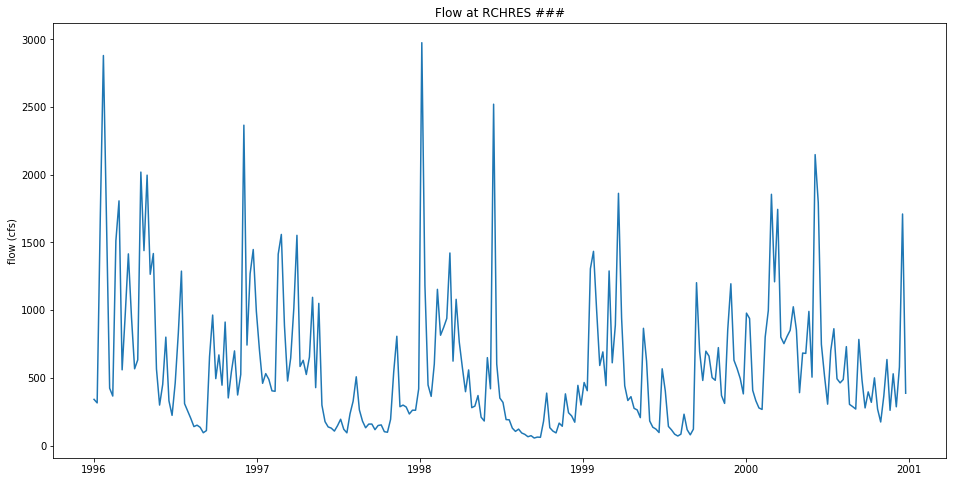

In [4]:
# Create Plot of Mean Monthly Flow from 2000 to 2010
m_plt.figure(figsize=(16,8))
m_plt.plot(df1['FLOW (ft3/s)']['1996':'2000'].resample('7D').mean())
m_plt.title('Flow at RCHRES ###')
m_plt.ylabel('flow (cfs)')

In [5]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [6]:
# Create a dataframe for just flow
dfFlow = df1['FLOW (ft3/s)']

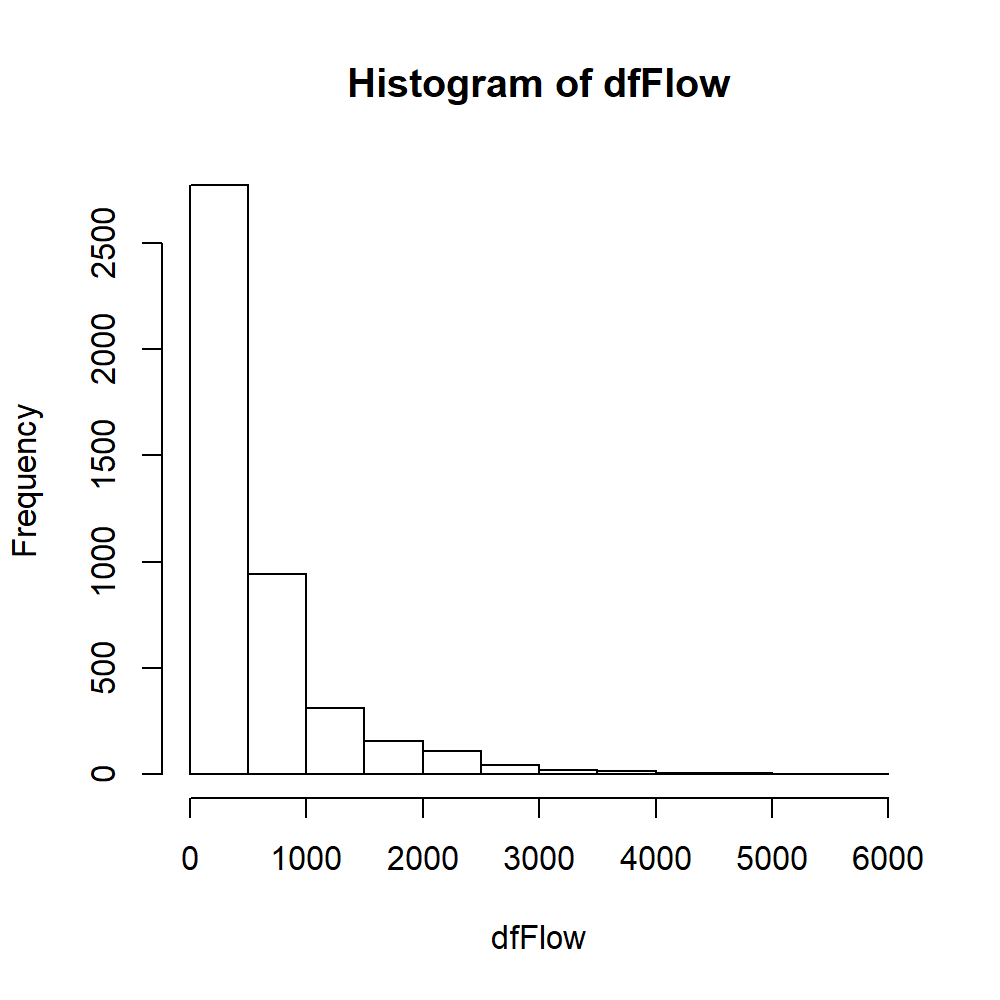

In [7]:
%%R -i dfFlow -w 5 -h 5 --units in -r 200
# import df1 from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
# library(ggplot2)
hist(dfFlow)